# Instalación de paquetes

In [ ]:
print("Installing the tensorflow-io-nightly package !")
!pip install tensorflow-io-nightly

print("Installing the kafka-python package !")
!pip install kafka-python


Installing the tensorflow-io-nightly package !
     |████████████████████████████████| 22.4MB 1.3MB/s 
Installing the kafka-python package !
     |████████████████████████████████| 256kB 2.8MB/s 


# Listado de paquetes de importación

In [ ]:
import os
from datetime import datetime
import time
import threading
import json
from kafka import KafkaProducer
from kafka.errors import KafkaError
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio

In [ ]:
print("tensorflow-io version: {}".format(tfio.__version__))
print("tensorflow version: {}".format(tf.__version__))

tensorflow-io version: 0.15.0
tensorflow version: 2.3.0


# Descargar y configuración de Kafka

In [ ]:
!curl -sSOL http://packages.confluent.io/archive/5.4/confluent-community-5.4.1-2.12.tar.gz
!tar -xzf confluent-community-5.4.1-2.12.tar.gz

Usamos los archivos de configuración provistos por Confluent Package 

In [ ]:
!cd confluent-5.4.1 && bin/zookeeper-server-start -daemon etc/kafka/zookeeper.properties
!cd confluent-5.4.1 && bin/kafka-server-start -daemon etc/kafka/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


Estas instancias han creado un demonio (Procesos Java) los cuales podemos visualizar con el siguiente comando 


In [ ]:
!ps -ef | grep kafka

root         217       1  2 17:02 ?        00:00:02 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -Djava.awt.headless=true -Xlog:gc*:file=/content/confluent-5.4.1/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=102400 -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/confluent-5.4.1/bin/../logs -Dlog4j.configuration=file:bin/../etc/kafka/log4j.properties -cp /content/confluent-5.4.1/bin/../share/java/kafka/*:/content/confluent-5.4.1/bin/../support-metrics-client/build/dependant-libs-2.12.10/*:/content/confluent-5.4.1/bin/../support-metrics-client/build/libs/*:/usr/share/java/support-metrics-client/* org.apache.zookeeper.server.quorum.QuorumPeerMain etc/kafka/zookeeper.properties
root         261       1  9 17:02 ?        00:00:09 java -Xmx1G -Xms1G -server -XX:+UseG1GC -XX:MaxGCPauseMi

Ahora crearemos un topico de Kafka con las siguientes especificaciones:
```
#RFCE-train: partitions=1, replication-factor=1
#RFCE-test: partitions=2, replication-factor=1
```



In [ ]:
!confluent-5.4.1/bin/kafka-topics --create --zookeeper 127.0.0.1:2181 --replication-factor 1 --partitions 1 --topic RFCE-train
!confluent-5.4.1/bin/kafka-topics --create --zookeeper 127.0.0.1:2181 --replication-factor 1 --partitions 2 --topic RFCE-test

Created topic RFCE-train.
Created topic RFCE-test.


Describiremos el topico con los detalle de la configuración.

In [ ]:
!confluent-5.4.1/bin/kafka-topics --bootstrap-server 127.0.0.1:9092 --describe --topic RFCE-train
!confluent-5.4.1/bin/kafka-topics --bootstrap-server 127.0.0.1:9092 --describe --topic RFCE-test

Topic: RFCE-train	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: RFCE-train	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: RFCE-test	PartitionCount: 2	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: RFCE-test	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
	Topic: RFCE-test	Partition: 1	Leader: 0	Replicas: 0	Isr: 0


# Iniciando la carga de datos y exploración del dataset

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth  
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#aca se puede editar el modelo y colocar cualquier red neuronal

In [ ]:
path = '/content/drive/My Drive/Adquisicion/MONGO_SPARK/Kafka-Ejercicios (1)/Kafka/PrediccionPm2.5-MLP/datasets'
os.chdir(path)
df = pd.read_csv('TestData.txt')

In [ ]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8661.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,39444.500000,2014.0,6.526027,15.720548,11.500000,97.734557,2.052169,13.679566,1016.637557,19.618643,0.033904,0.135616
std,2528.938512,0.0,3.448048,8.796749,6.922582,93.531528,14.162550,11.648796,9.797063,44.221399,0.704797,1.070038
min,35065.000000,2014.0,1.000000,1.000000,0.000000,2.000000,-40.000000,-13.000000,993.000000,0.450000,0.000000,0.000000
25%,37254.750000,2014.0,4.000000,8.000000,5.750000,28.000000,-9.000000,3.000000,1008.000000,1.790000,0.000000,0.000000
50%,39444.500000,2014.0,7.000000,16.000000,11.500000,72.000000,4.000000,15.000000,1016.000000,4.910000,0.000000,0.000000
75%,41634.250000,2014.0,10.000000,23.000000,17.250000,133.000000,15.000000,23.000000,1025.000000,17.430000,0.000000,0.000000
max,43824.000000,2014.0,12.000000,31.000000,23.000000,671.000000,25.000000,42.000000,1039.000000,441.180000,23.000000,23.000000


In [ ]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,35065,2014,1,1,0,24.0,-20,7.0,1014,NW,143.48,0,0
1,35066,2014,1,1,1,53.0,-20,7.0,1013,NW,147.50,0,0
2,35067,2014,1,1,2,65.0,-20,6.0,1013,NW,151.52,0,0
3,35068,2014,1,1,3,70.0,-20,6.0,1013,NW,153.31,0,0
4,35069,2014,1,1,4,79.0,-18,3.0,1012,cv,0.89,0,0


In [ ]:
print(df)

         No  year  month  day  hour  pm2.5  ...  TEMP  PRES  cbwd     Iws  Is  Ir
0     35065  2014      1    1     0   24.0  ...   7.0  1014    NW  143.48   0   0
1     35066  2014      1    1     1   53.0  ...   7.0  1013    NW  147.50   0   0
2     35067  2014      1    1     2   65.0  ...   6.0  1013    NW  151.52   0   0
3     35068  2014      1    1     3   70.0  ...   6.0  1013    NW  153.31   0   0
4     35069  2014      1    1     4   79.0  ...   3.0  1012    cv    0.89   0   0
...     ...   ...    ...  ...   ...    ...  ...   ...   ...   ...     ...  ..  ..
8755  43820  2014     12   31    19    8.0  ...  -2.0  1034    NW  231.97   0   0
8756  43821  2014     12   31    20   10.0  ...  -3.0  1034    NW  237.78   0   0
8757  43822  2014     12   31    21   10.0  ...  -3.0  1034    NW  242.70   0   0
8758  43823  2014     12   31    22    8.0  ...  -4.0  1034    NW  246.72   0   0
8759  43824  2014     12   31    23   12.0  ...  -3.0  1034    NW  249.85   0   0

[8760 rows x 13

Limpieza de datos 

In [ ]:
df.dropna(subset=['pm2.5'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
print(df)

         No  year  month  day  hour  pm2.5  ...  TEMP  PRES  cbwd     Iws  Is  Ir
0     35065  2014      1    1     0   24.0  ...   7.0  1014    NW  143.48   0   0
1     35066  2014      1    1     1   53.0  ...   7.0  1013    NW  147.50   0   0
2     35067  2014      1    1     2   65.0  ...   6.0  1013    NW  151.52   0   0
3     35068  2014      1    1     3   70.0  ...   6.0  1013    NW  153.31   0   0
4     35069  2014      1    1     4   79.0  ...   3.0  1012    cv    0.89   0   0
...     ...   ...    ...  ...   ...    ...  ...   ...   ...   ...     ...  ..  ..
8656  43820  2014     12   31    19    8.0  ...  -2.0  1034    NW  231.97   0   0
8657  43821  2014     12   31    20   10.0  ...  -3.0  1034    NW  237.78   0   0
8658  43822  2014     12   31    21   10.0  ...  -3.0  1034    NW  242.70   0   0
8659  43823  2014     12   31    22    8.0  ...  -4.0  1034    NW  246.72   0   0
8660  43824  2014     12   31    23   12.0  ...  -3.0  1034    NW  249.85   0   0

[8661 rows x 13

In [ ]:
import datetime
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],
                                                                                          hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

Visualización de los datos


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Box plot of pm2.5')

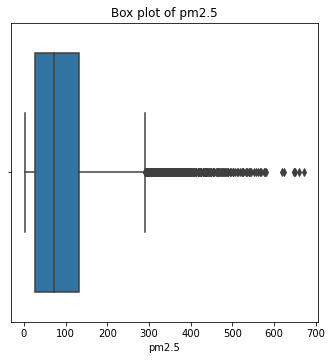

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['pm2.5'])
g.set_title('Box plot of pm2.5')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


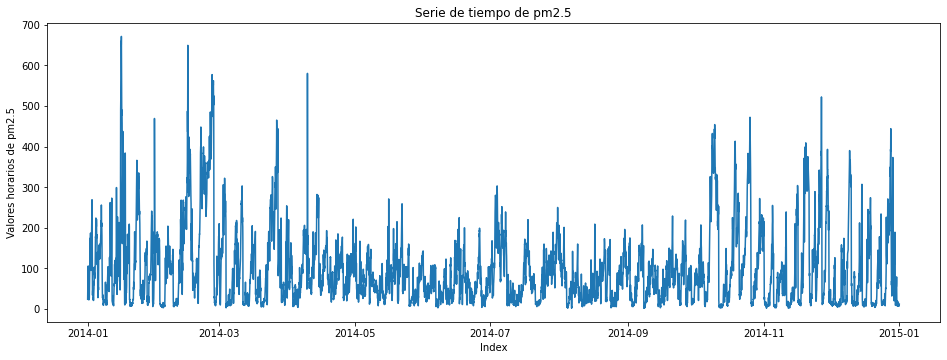

In [ ]:
plt.figure(figsize=(16, 5.5))
g = sns.lineplot(df['datetime'],df['pm2.5'])
g.set_title('Serie de tiempo de pm2.5')
g.set_xlabel('Index')
g.set_ylabel('Valores horarios de pm2.5')
plt.savefig('B07887_05_10.png', format='png', dpi=300)

Agrega una columna con los datos ajustados

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_pm2.5'] = scaler.fit_transform(np.array(df['pm2.5']).reshape(-1, 1))

Ahora visualizamos los conjunto de datos 


In [ ]:
# Utilizamos pandas para realizar este proceso. 
split_date = datetime.datetime(year=2014, month=11, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_test = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_test.shape)

Shape of train: (7239, 15)
Shape of test: (1422, 15)


In [ ]:
df_train.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_pm2.5
0,35065,2014,1,1,0,24.0,-20,7.0,1014,NW,143.48,0,0,2014-01-01 00:00:00,0.032885
1,35066,2014,1,1,1,53.0,-20,7.0,1013,NW,147.50,0,0,2014-01-01 01:00:00,0.076233
2,35067,2014,1,1,2,65.0,-20,6.0,1013,NW,151.52,0,0,2014-01-01 02:00:00,0.094170
3,35068,2014,1,1,3,70.0,-20,6.0,1013,NW,153.31,0,0,2014-01-01 03:00:00,0.101644
4,35069,2014,1,1,4,79.0,-18,3.0,1012,cv,0.89,0,0,2014-01-01 04:00:00,0.115097


In [ ]:
df_test.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime,scaled_pm2.5
7239,42361,2014,11,1,0,180.0,10,13.0,1019,NW,1.79,0,0,2014-11-01 00:00:00,0.266069
7240,42362,2014,11,1,1,189.0,8,9.0,1019,cv,0.89,0,0,2014-11-01 01:00:00,0.279522
7241,42363,2014,11,1,2,215.0,8,9.0,1019,cv,1.34,0,0,2014-11-01 02:00:00,0.318386
7242,42364,2014,11,1,3,180.0,8,8.0,1019,NW,1.79,0,0,2014-11-01 03:00:00,0.266069
7243,42365,2014,11,1,4,81.0,6,6.0,1019,cv,0.89,0,0,2014-11-01 04:00:00,0.118087


In [ ]:
#Vamos a resetar los indices para ser ordenados 
df_test.reset_index(drop=True, inplace=True)

In [ ]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [ ]:
x_train, y_train = makeXy(df_train['scaled_pm2.5'], 7)
print('Shape of train arrays:', x_train.shape, y_train.shape)

Shape of train arrays: (7232, 7) (7232,)


In [ ]:
print(x_train)
print(y_train)

[[0.0328849  0.07623318 0.0941704  ... 0.11509716 0.13452915 0.1554559 ]
 [0.07623318 0.0941704  0.10164425 ... 0.13452915 0.1554559  0.10911809]
 [0.0941704  0.10164425 0.11509716 ... 0.1554559  0.10911809 0.08370703]
 ...
 [0.21076233 0.21375187 0.22421525 ... 0.26008969 0.30941704 0.33183857]
 [0.21375187 0.22421525 0.24364723 ... 0.30941704 0.33183857 0.29596413]
 [0.22421525 0.24364723 0.26008969 ... 0.33183857 0.29596413 0.27802691]]
[0.10911809 0.08370703 0.04633782 ... 0.29596413 0.27802691 0.27204783]


In [ ]:
x_test, y_test = makeXy(df_test['scaled_pm2.5'], 7)
print('Shape of validation arrays:', x_test.shape, y_test.shape)

Shape of validation arrays: (1415, 7) (1415,)


In [ ]:
x_train_df = pd.DataFrame(data=x_train)
y_train_df = pd.DataFrame(data=y_train)
x_test_df = pd.DataFrame(data=x_test)
y_test_df = pd.DataFrame(data=y_test)

#Preparación de datos para enviarlos al Kafka

In [ ]:
x_train = list(filter(None, x_train_df.to_csv(index=False).split("\n")[1:]))
y_train = list(filter(None, y_train_df.to_csv(index=False).split("\n")[1:]))

x_test = list(filter(None, x_test_df.to_csv(index=False).split("\n")[1:]))
y_test = list(filter(None, y_test_df.to_csv(index=False).split("\n")[1:]))

In [ ]:
def error_callback(exc):
    raise Exception('Error while sendig data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, items):
  count=0
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  for message, key in items:
    producer.send(topic_name, key=key.encode('utf-8'), value=message.encode('utf-8')).add_errback(error_callback)
    count+=1
  producer.flush()
  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

write_to_kafka("RFCE-train", zip(x_train, y_train))
write_to_kafka("RFCE-test", zip(x_test, y_test))

Wrote 7232 messages into topic: RFCE-train
Wrote 1415 messages into topic: RFCE-test


In [ ]:
NUM_COLUMNS = len(x_train_df.columns)
len(x_train), len(y_train), len(x_test), len(y_test)
print(NUM_COLUMNS)

7


In [ ]:
def decode_kafka_item(item):
  message = tf.io.decode_csv(item.message, [[0.0] for i in range(NUM_COLUMNS)])
  key = tf.strings.to_number(item.key)
  return (message, key)

BATCH_SIZE=64
SHUFFLE_BUFFER_SIZE=64
train_ds = tfio.IODataset.from_kafka('RFCE-train', partition=0, offset=0)
train_ds = train_ds.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
train_ds = train_ds.map(decode_kafka_item)
train_ds = train_ds.batch(BATCH_SIZE)

In [ ]:
# Set the parameters

OPTIMIZER="adam"
LOSS=tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS=['accuracy']
EPOCHS=20

In [ ]:
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import ZeroPadding1D
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import AveragePooling1D
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [ ]:
input_layer = Input(shape=(7,1), dtype='float32')
zeropadding_layer = ZeroPadding1D(padding=1)(input_layer)
conv1D_layer1 = Conv1D(64, 3, strides=1, use_bias=True)(zeropadding_layer)
conv1D_layer2 = Conv1D(32, 3, strides=1, use_bias=True)(conv1D_layer1)
avgpooling_layer = AveragePooling1D(pool_size=3, strides=1)(conv1D_layer2)
flatten_layer = Flatten()(avgpooling_layer)
dense_layer1 = Dense(32)(avgpooling_layer)
dense_layer2 = Dense(16)(dense_layer1)
dropout_layer = Dropout(0.2)(flatten_layer)
output_layer = Dense(1, activation='linear')(dropout_layer)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_absolute_error', optimizer='adam')#SGD(lr=0.001, decay=1e-5))
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
zero_padding1d_2 (ZeroPaddin (None, 9, 1)              0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 7, 64)             256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 32)             6176      
_________________________________________________________________
average_pooling1d_2 (Average (None, 3, 32)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 96)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 96)               

In [ ]:
# compile the model
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [ ]:
# fit the model
model.fit(train_ds, epochs=20)

Epoch 1/20
170/170 [==============================] - 5s 30ms/step - loss: 0.4373 - accuracy: 4.6155e-04
Epoch 2/20
170/170 [==============================] - 5s 30ms/step - loss: 0.3745 - accuracy: 6.4617e-04
Epoch 3/20
170/170 [==============================] - 5s 30ms/step - loss: 0.3727 - accuracy: 6.4617e-04
Epoch 4/20
170/170 [==============================] - 5s 30ms/step - loss: 0.3714 - accuracy: 6.4617e-04
Epoch 5/20
170/170 [==============================] - 5s 30ms/step - loss: 0.3708 - accuracy: 6.4617e-04
Epoch 6/20
170/170 [==============================] - 5s 30ms/step - loss: 0.3703 - accuracy: 6.4617e-04
Epoch 7/20
170/170 [==============================] - 5s 30ms/step - loss: 0.3698 - accuracy: 6.4617e-04
Epoch 8/20
170/170 [==============================] - 5s 30ms/step - loss: 0.3694 - accuracy: 6.4617e-04
Epoch 9/20
170/170 [==============================] - 5s 30ms/step - loss: 0.3693 - accuracy: 6.4617e-04
Epoch 10/20
170/170 [==============================] - 

In [ ]:
test_ds = tfio.experimental.streaming.KafkaGroupIODataset(
    topics=["RFCE-test"],
    group_id="testcg",
    servers="127.0.0.1:9092",
    stream_timeout=10000,
    configuration=[
        "session.timeout.ms=7000",
        "max.poll.interval.ms=8000",
        "auto.offset.reset=earliest"
    ],
)

def decode_kafka_test_item(raw_message, raw_key):
  message = tf.io.decode_csv(raw_message, [[0.0] for i in range(NUM_COLUMNS)])
  key = tf.strings.to_number(raw_key)
  return (message, key)

test_ds = test_ds.map(decode_kafka_test_item)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
res = model.evaluate(test_ds)
print("test loss, test acc:", res)


101/101 [==============================] - 11s 104ms/step - loss: 0.3266 - accuracy: 0.0017
test loss, test acc: [0.32655268907546997, 0.0017025228589773178]


In [ ]:
!confluent-5.4.1/bin/kafka-consumer-groups --bootstrap-server 127.0.0.1:9092 --describe --group testcg

/bin/bash: confluent-5.4.1/bin/kafka-consumer-groups: No such file or directory
